<a href="https://colab.research.google.com/github/DimpleB0501/eva8/blob/main/Session_6_Assignment_QnA/backup/S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10


Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# GPU Check

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



# Ablumentations library


In [ ]:
# Import dependencies
!!pip install --upgrade albumentations
!pip install torchscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import copy
import random
import matplotlib.pyplot as plt

In [ ]:
def train_transform_func():
  train_transform = A.Compose(
      [
      A.HorizontalFlip(p=0.5),
      A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),  
      A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=1, min_width=1, fill_value=tuple([0.485, 0.456, 0.406]), mask_fill_value = None), 
      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
      ToTensorV2(),
      ]
  )
  return lambda img:train_transform(image=np.array(img))["image"]

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform_func())

Files already downloaded and verified


In [ ]:
test_transform = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                                       ])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

# test dataloader
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let us show some of the training images, for fun.



 ship  bird   cat   dog


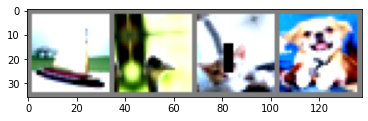

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

:2. Define a Convolution Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # 32 | 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        ) # 32 | 30
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        ) # 30 | 28
        self.conv3b = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        ) # 28 | 28
        '''
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride = 2, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        ) # 30 | 28 # ip = 28 | op = 14 
        '''
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(2, 2), stride = 2, padding=2, dilation = 4, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        ) # 30 | 28 # ip = 28 | op = 14 
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=100, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(100)
        ) # 14 | 12
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=100, out_channels=64, kernel_size=(3, 3), padding=1, dilation = 2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        ) # 12 | 10
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=1, dilation = 2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        ) # 10 | 8

        self.depthwise_separable_conv = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3, 3), padding = 0, groups = 32, bias = False),
            nn.Conv2d(in_channels = 32, out_channels = 20, kernel_size = (1, 1), padding = 0, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(20)
        ) # 8 | 6

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # 6 | 4

        # GAP layer
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # ip = 10 | op = 1 

        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # ip = 1 | op = 1 | RF = 28

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv3b(x)
        x = self.pool1(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.depthwise_separable_conv(x)
        x = self.conv7(x)
        x = self.gap(x)
        x = self.conv8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
from torchscan import summary

device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, (3, 32, 32), receptive_field=True, max_depth=1)

cuda
___________________________________________________________________________________________
Layer                         Type          Output Shape         Param #    Receptive field
net                           Net           (-1, 10)             0          1              
├─conv1                       Sequential    (-1, 16, 32, 32)     497        3              
├─conv2                       Sequential    (-1, 32, 30, 30)     4,737      5              
├─conv3                       Sequential    (-1, 64, 28, 28)     18,689     7              
├─conv3b                      Sequential    (-1, 32, 28, 28)     18,561     9              
├─pool1                       Sequential    (-1, 64, 14, 14)     8,449      13             
├─conv4                       Sequential    (-1, 100, 12, 12)    58,001     17             
├─conv5                       Sequential    (-1, 64, 10, 10)     57,857     25             
├─conv6                       Sequential    (-1, 32, 8, 8)       18,561    

3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

EPOCH: 0


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.5127655267715454 Batch_id=390 Accuracy=37.95: 100%|██████████| 391/391 [00:17<00:00, 22.61it/s]



Test set: Average loss: 1.3486, Accuracy: 5152/10000 (51.52%)

EPOCH: 1


Loss=1.2934973239898682 Batch_id=390 Accuracy=51.27: 100%|██████████| 391/391 [00:18<00:00, 20.70it/s]



Test set: Average loss: 1.1264, Accuracy: 6018/10000 (60.18%)

EPOCH: 2


Loss=1.1495840549468994 Batch_id=390 Accuracy=57.46: 100%|██████████| 391/391 [00:14<00:00, 26.23it/s]



Test set: Average loss: 0.9262, Accuracy: 6763/10000 (67.63%)

EPOCH: 3


Loss=0.8196481466293335 Batch_id=390 Accuracy=61.92: 100%|██████████| 391/391 [00:14<00:00, 26.65it/s]



Test set: Average loss: 0.8663, Accuracy: 6995/10000 (69.95%)

EPOCH: 4


Loss=1.0159142017364502 Batch_id=390 Accuracy=64.68: 100%|██████████| 391/391 [00:14<00:00, 27.30it/s]



Test set: Average loss: 0.7824, Accuracy: 7233/10000 (72.33%)

EPOCH: 5


Loss=0.950154185295105 Batch_id=390 Accuracy=66.88: 100%|██████████| 391/391 [00:14<00:00, 27.28it/s]



Test set: Average loss: 0.7285, Accuracy: 7454/10000 (74.54%)

EPOCH: 6


Loss=0.9476416707038879 Batch_id=390 Accuracy=68.61: 100%|██████████| 391/391 [00:14<00:00, 26.15it/s]



Test set: Average loss: 0.7008, Accuracy: 7574/10000 (75.74%)

EPOCH: 7


Loss=0.857933521270752 Batch_id=390 Accuracy=69.92: 100%|██████████| 391/391 [00:14<00:00, 26.62it/s]



Test set: Average loss: 0.6532, Accuracy: 7759/10000 (77.59%)

EPOCH: 8


Loss=0.9173291325569153 Batch_id=390 Accuracy=71.56: 100%|██████████| 391/391 [00:14<00:00, 26.66it/s]



Test set: Average loss: 0.5804, Accuracy: 8008/10000 (80.08%)

EPOCH: 9


Loss=0.7719423770904541 Batch_id=390 Accuracy=72.79: 100%|██████████| 391/391 [00:15<00:00, 25.01it/s]



Test set: Average loss: 0.5732, Accuracy: 8039/10000 (80.39%)

EPOCH: 10


Loss=0.9695185422897339 Batch_id=390 Accuracy=73.63: 100%|██████████| 391/391 [00:14<00:00, 26.73it/s]



Test set: Average loss: 0.5727, Accuracy: 8040/10000 (80.40%)

EPOCH: 11


Loss=0.665337324142456 Batch_id=390 Accuracy=74.45: 100%|██████████| 391/391 [00:14<00:00, 27.16it/s]



Test set: Average loss: 0.5721, Accuracy: 8062/10000 (80.62%)

EPOCH: 12


Loss=0.5873953700065613 Batch_id=390 Accuracy=75.30: 100%|██████████| 391/391 [00:14<00:00, 27.00it/s]



Test set: Average loss: 0.5269, Accuracy: 8198/10000 (81.98%)

EPOCH: 13


Loss=0.7554229497909546 Batch_id=390 Accuracy=76.03: 100%|██████████| 391/391 [00:14<00:00, 26.48it/s]



Test set: Average loss: 0.5075, Accuracy: 8275/10000 (82.75%)

EPOCH: 14


Loss=0.6182581782341003 Batch_id=390 Accuracy=76.20: 100%|██████████| 391/391 [00:14<00:00, 26.08it/s]



Test set: Average loss: 0.5041, Accuracy: 8258/10000 (82.58%)

EPOCH: 15


Loss=0.882501482963562 Batch_id=390 Accuracy=77.37: 100%|██████████| 391/391 [00:14<00:00, 26.76it/s]



Test set: Average loss: 0.4964, Accuracy: 8304/10000 (83.04%)

EPOCH: 16


Loss=0.5434976816177368 Batch_id=390 Accuracy=77.55: 100%|██████████| 391/391 [00:14<00:00, 26.80it/s]



Test set: Average loss: 0.4725, Accuracy: 8357/10000 (83.57%)

EPOCH: 17


Loss=0.6300684213638306 Batch_id=390 Accuracy=77.91: 100%|██████████| 391/391 [00:14<00:00, 26.90it/s]



Test set: Average loss: 0.4564, Accuracy: 8464/10000 (84.64%)

EPOCH: 18


Loss=0.629723846912384 Batch_id=390 Accuracy=78.40: 100%|██████████| 391/391 [00:14<00:00, 27.42it/s]



Test set: Average loss: 0.4563, Accuracy: 8444/10000 (84.44%)

EPOCH: 19


Loss=0.760962724685669 Batch_id=390 Accuracy=78.87: 100%|██████████| 391/391 [00:14<00:00, 26.94it/s]



Test set: Average loss: 0.4516, Accuracy: 8448/10000 (84.48%)

EPOCH: 20


Loss=0.5580017566680908 Batch_id=390 Accuracy=79.20: 100%|██████████| 391/391 [00:14<00:00, 27.44it/s]



Test set: Average loss: 0.4581, Accuracy: 8422/10000 (84.22%)

EPOCH: 21


Loss=0.6256848573684692 Batch_id=390 Accuracy=79.38: 100%|██████████| 391/391 [00:14<00:00, 27.20it/s]



Test set: Average loss: 0.4506, Accuracy: 8483/10000 (84.83%)

EPOCH: 22


Loss=0.5485574007034302 Batch_id=390 Accuracy=79.72: 100%|██████████| 391/391 [00:14<00:00, 26.89it/s]



Test set: Average loss: 0.4434, Accuracy: 8462/10000 (84.62%)

EPOCH: 23


Loss=0.7530108094215393 Batch_id=390 Accuracy=80.07: 100%|██████████| 391/391 [00:14<00:00, 27.10it/s]



Test set: Average loss: 0.4496, Accuracy: 8446/10000 (84.46%)

EPOCH: 24


Loss=0.6204602122306824 Batch_id=390 Accuracy=80.33: 100%|██████████| 391/391 [00:15<00:00, 25.46it/s]



Test set: Average loss: 0.4213, Accuracy: 8569/10000 (85.69%)

EPOCH: 25


Loss=0.6267459392547607 Batch_id=390 Accuracy=80.69: 100%|██████████| 391/391 [00:14<00:00, 26.90it/s]



Test set: Average loss: 0.4330, Accuracy: 8495/10000 (84.95%)

EPOCH: 26


Loss=0.3798222243785858 Batch_id=390 Accuracy=81.04: 100%|██████████| 391/391 [00:14<00:00, 26.74it/s]



Test set: Average loss: 0.4239, Accuracy: 8575/10000 (85.75%)

EPOCH: 27


Loss=0.7490525245666504 Batch_id=390 Accuracy=81.22: 100%|██████████| 391/391 [00:14<00:00, 26.66it/s]



Test set: Average loss: 0.4088, Accuracy: 8613/10000 (86.13%)

EPOCH: 28


Loss=0.3291148245334625 Batch_id=390 Accuracy=81.36: 100%|██████████| 391/391 [00:14<00:00, 27.18it/s]



Test set: Average loss: 0.4192, Accuracy: 8573/10000 (85.73%)

EPOCH: 29


Loss=0.5590541362762451 Batch_id=390 Accuracy=81.87: 100%|██████████| 391/391 [00:14<00:00, 27.18it/s]



Test set: Average loss: 0.4030, Accuracy: 8621/10000 (86.21%)

EPOCH: 30


Loss=0.4898350238800049 Batch_id=390 Accuracy=81.55: 100%|██████████| 391/391 [00:14<00:00, 27.11it/s]



Test set: Average loss: 0.3979, Accuracy: 8652/10000 (86.52%)

EPOCH: 31


Loss=0.6622996926307678 Batch_id=390 Accuracy=82.10: 100%|██████████| 391/391 [00:14<00:00, 27.10it/s]



Test set: Average loss: 0.4159, Accuracy: 8582/10000 (85.82%)

EPOCH: 32


Loss=0.4820632040500641 Batch_id=390 Accuracy=82.22: 100%|██████████| 391/391 [00:14<00:00, 26.65it/s]



Test set: Average loss: 0.4064, Accuracy: 8633/10000 (86.33%)

EPOCH: 33


Loss=0.5406879186630249 Batch_id=390 Accuracy=82.56: 100%|██████████| 391/391 [00:14<00:00, 26.82it/s]



Test set: Average loss: 0.3976, Accuracy: 8658/10000 (86.58%)

EPOCH: 34


Loss=0.32180625200271606 Batch_id=390 Accuracy=82.64: 100%|██████████| 391/391 [00:14<00:00, 27.35it/s]



Test set: Average loss: 0.4005, Accuracy: 8637/10000 (86.37%)

EPOCH: 35


Loss=0.5290950536727905 Batch_id=390 Accuracy=82.60: 100%|██████████| 391/391 [00:14<00:00, 26.82it/s]



Test set: Average loss: 0.3907, Accuracy: 8620/10000 (86.20%)

EPOCH: 36


Loss=0.5135248899459839 Batch_id=390 Accuracy=82.99: 100%|██████████| 391/391 [00:14<00:00, 26.68it/s]



Test set: Average loss: 0.3859, Accuracy: 8678/10000 (86.78%)

EPOCH: 37


Loss=0.3214549124240875 Batch_id=390 Accuracy=82.71: 100%|██████████| 391/391 [00:15<00:00, 25.10it/s]



Test set: Average loss: 0.3865, Accuracy: 8689/10000 (86.89%)

EPOCH: 38


Loss=0.3691864013671875 Batch_id=390 Accuracy=82.97: 100%|██████████| 391/391 [00:14<00:00, 27.40it/s]



Test set: Average loss: 0.3887, Accuracy: 8659/10000 (86.59%)

EPOCH: 39


Loss=0.41213828325271606 Batch_id=390 Accuracy=83.28: 100%|██████████| 391/391 [00:14<00:00, 27.06it/s]



Test set: Average loss: 0.3871, Accuracy: 8712/10000 (87.12%)

EPOCH: 40


Loss=0.43224018812179565 Batch_id=390 Accuracy=83.35: 100%|██████████| 391/391 [00:14<00:00, 26.99it/s]



Test set: Average loss: 0.3902, Accuracy: 8706/10000 (87.06%)

EPOCH: 41


Loss=0.405611127614975 Batch_id=390 Accuracy=83.75: 100%|██████████| 391/391 [00:14<00:00, 26.98it/s]



Test set: Average loss: 0.3717, Accuracy: 8764/10000 (87.64%)

EPOCH: 42


Loss=0.5657268762588501 Batch_id=390 Accuracy=83.69: 100%|██████████| 391/391 [00:14<00:00, 26.86it/s]



Test set: Average loss: 0.3808, Accuracy: 8719/10000 (87.19%)

EPOCH: 43


Loss=0.4435543119907379 Batch_id=390 Accuracy=83.59: 100%|██████████| 391/391 [00:14<00:00, 27.05it/s]



Test set: Average loss: 0.3772, Accuracy: 8744/10000 (87.44%)

EPOCH: 44


Loss=0.6249765157699585 Batch_id=390 Accuracy=83.92: 100%|██████████| 391/391 [00:14<00:00, 27.26it/s]



Test set: Average loss: 0.3781, Accuracy: 8729/10000 (87.29%)

EPOCH: 45


Loss=0.3798156678676605 Batch_id=390 Accuracy=83.98: 100%|██████████| 391/391 [00:14<00:00, 26.59it/s]



Test set: Average loss: 0.4022, Accuracy: 8653/10000 (86.53%)

EPOCH: 46


Loss=0.4839811325073242 Batch_id=390 Accuracy=84.02: 100%|██████████| 391/391 [00:14<00:00, 26.85it/s]



Test set: Average loss: 0.3666, Accuracy: 8735/10000 (87.35%)

EPOCH: 47


Loss=0.51535564661026 Batch_id=390 Accuracy=84.10: 100%|██████████| 391/391 [00:14<00:00, 27.20it/s]



Test set: Average loss: 0.3769, Accuracy: 8709/10000 (87.09%)

EPOCH: 48


Loss=0.3414994180202484 Batch_id=390 Accuracy=84.56: 100%|██████████| 391/391 [00:14<00:00, 26.98it/s]



Test set: Average loss: 0.3593, Accuracy: 8812/10000 (88.12%)

EPOCH: 49


Loss=0.5591815114021301 Batch_id=390 Accuracy=84.28: 100%|██████████| 391/391 [00:14<00:00, 26.71it/s]



Test set: Average loss: 0.3673, Accuracy: 8753/10000 (87.53%)

EPOCH: 50


Loss=0.5228939652442932 Batch_id=390 Accuracy=84.54: 100%|██████████| 391/391 [00:15<00:00, 24.63it/s]



Test set: Average loss: 0.3751, Accuracy: 8728/10000 (87.28%)

EPOCH: 51


Loss=0.4232260286808014 Batch_id=390 Accuracy=84.65: 100%|██████████| 391/391 [00:14<00:00, 26.85it/s]



Test set: Average loss: 0.3608, Accuracy: 8797/10000 (87.97%)

EPOCH: 52


Loss=0.40077686309814453 Batch_id=390 Accuracy=84.96: 100%|██████████| 391/391 [00:14<00:00, 26.76it/s]



Test set: Average loss: 0.3691, Accuracy: 8759/10000 (87.59%)

EPOCH: 53


Loss=0.35843372344970703 Batch_id=390 Accuracy=84.65: 100%|██████████| 391/391 [00:14<00:00, 26.81it/s]



Test set: Average loss: 0.3554, Accuracy: 8801/10000 (88.01%)

EPOCH: 54


Loss=0.4007245898246765 Batch_id=390 Accuracy=84.93: 100%|██████████| 391/391 [00:14<00:00, 26.89it/s]



Test set: Average loss: 0.3538, Accuracy: 8786/10000 (87.86%)

EPOCH: 55


Loss=0.4065690040588379 Batch_id=390 Accuracy=85.05: 100%|██████████| 391/391 [00:14<00:00, 26.65it/s]



Test set: Average loss: 0.3537, Accuracy: 8814/10000 (88.14%)

EPOCH: 56


Loss=0.5057264566421509 Batch_id=390 Accuracy=85.14: 100%|██████████| 391/391 [00:14<00:00, 27.08it/s]



Test set: Average loss: 0.3542, Accuracy: 8795/10000 (87.95%)

EPOCH: 57


Loss=0.32864198088645935 Batch_id=390 Accuracy=85.17: 100%|██████████| 391/391 [00:14<00:00, 26.81it/s]



Test set: Average loss: 0.3598, Accuracy: 8765/10000 (87.65%)

EPOCH: 58


Loss=0.3544818162918091 Batch_id=390 Accuracy=85.45: 100%|██████████| 391/391 [00:14<00:00, 27.21it/s]



Test set: Average loss: 0.3577, Accuracy: 8787/10000 (87.87%)

EPOCH: 59


Loss=0.29616275429725647 Batch_id=390 Accuracy=85.55: 100%|██████████| 391/391 [00:14<00:00, 26.97it/s]



Test set: Average loss: 0.3634, Accuracy: 8771/10000 (87.71%)

EPOCH: 60


Loss=0.43222928047180176 Batch_id=390 Accuracy=85.51: 100%|██████████| 391/391 [00:14<00:00, 26.98it/s]



Test set: Average loss: 0.3507, Accuracy: 8803/10000 (88.03%)

EPOCH: 61


Loss=0.4810360372066498 Batch_id=390 Accuracy=85.67: 100%|██████████| 391/391 [00:14<00:00, 26.58it/s]



Test set: Average loss: 0.3549, Accuracy: 8804/10000 (88.04%)

EPOCH: 62


Loss=0.697860836982727 Batch_id=390 Accuracy=85.36: 100%|██████████| 391/391 [00:14<00:00, 26.68it/s]



Test set: Average loss: 0.3504, Accuracy: 8793/10000 (87.93%)

EPOCH: 63


Loss=0.4361410140991211 Batch_id=390 Accuracy=85.94: 100%|██████████| 391/391 [00:15<00:00, 24.92it/s]



Test set: Average loss: 0.3643, Accuracy: 8754/10000 (87.54%)

EPOCH: 64


Loss=0.38681530952453613 Batch_id=390 Accuracy=85.74: 100%|██████████| 391/391 [00:14<00:00, 26.71it/s]



Test set: Average loss: 0.3412, Accuracy: 8851/10000 (88.51%)

EPOCH: 65


Loss=0.4762943685054779 Batch_id=390 Accuracy=85.89: 100%|██████████| 391/391 [00:14<00:00, 26.79it/s]



Test set: Average loss: 0.3548, Accuracy: 8800/10000 (88.00%)

EPOCH: 66


Loss=0.5295321345329285 Batch_id=390 Accuracy=85.89: 100%|██████████| 391/391 [00:14<00:00, 26.90it/s]



Test set: Average loss: 0.3496, Accuracy: 8850/10000 (88.50%)

EPOCH: 67


Loss=0.47660860419273376 Batch_id=390 Accuracy=86.11: 100%|██████████| 391/391 [00:14<00:00, 26.95it/s]



Test set: Average loss: 0.3511, Accuracy: 8823/10000 (88.23%)

EPOCH: 68


Loss=0.33223381638526917 Batch_id=390 Accuracy=86.01: 100%|██████████| 391/391 [00:14<00:00, 26.52it/s]



Test set: Average loss: 0.3442, Accuracy: 8862/10000 (88.62%)

EPOCH: 69


Loss=0.3725542426109314 Batch_id=390 Accuracy=86.15: 100%|██████████| 391/391 [00:14<00:00, 26.41it/s]



Test set: Average loss: 0.3523, Accuracy: 8846/10000 (88.46%)

EPOCH: 70


Loss=0.49272575974464417 Batch_id=390 Accuracy=86.05: 100%|██████████| 391/391 [00:14<00:00, 26.65it/s]



Test set: Average loss: 0.3502, Accuracy: 8820/10000 (88.20%)

EPOCH: 71


Loss=0.3315017819404602 Batch_id=390 Accuracy=86.21: 100%|██████████| 391/391 [00:14<00:00, 27.20it/s]



Test set: Average loss: 0.3515, Accuracy: 8828/10000 (88.28%)

EPOCH: 72


Loss=0.33695143461227417 Batch_id=390 Accuracy=86.35: 100%|██████████| 391/391 [00:14<00:00, 26.64it/s]



Test set: Average loss: 0.3443, Accuracy: 8824/10000 (88.24%)

EPOCH: 73


Loss=0.4214913249015808 Batch_id=390 Accuracy=86.49: 100%|██████████| 391/391 [00:14<00:00, 26.75it/s]



Test set: Average loss: 0.3476, Accuracy: 8833/10000 (88.33%)

EPOCH: 74


Loss=0.28871840238571167 Batch_id=390 Accuracy=86.16: 100%|██████████| 391/391 [00:14<00:00, 26.61it/s]



Test set: Average loss: 0.3551, Accuracy: 8841/10000 (88.41%)

EPOCH: 75


Loss=0.2868497967720032 Batch_id=390 Accuracy=86.35: 100%|██████████| 391/391 [00:14<00:00, 26.49it/s]



Test set: Average loss: 0.3475, Accuracy: 8830/10000 (88.30%)

EPOCH: 76


Loss=0.33089298009872437 Batch_id=390 Accuracy=86.43: 100%|██████████| 391/391 [00:15<00:00, 24.81it/s]



Test set: Average loss: 0.3553, Accuracy: 8820/10000 (88.20%)

EPOCH: 77


Loss=0.4373249411582947 Batch_id=390 Accuracy=86.66: 100%|██████████| 391/391 [00:14<00:00, 26.89it/s]



Test set: Average loss: 0.3436, Accuracy: 8838/10000 (88.38%)

EPOCH: 78


Loss=0.2772607207298279 Batch_id=390 Accuracy=86.57: 100%|██████████| 391/391 [00:14<00:00, 26.80it/s]



Test set: Average loss: 0.3511, Accuracy: 8824/10000 (88.24%)

EPOCH: 79


Loss=0.4685046672821045 Batch_id=390 Accuracy=86.84: 100%|██████████| 391/391 [00:15<00:00, 26.02it/s]



Test set: Average loss: 0.3476, Accuracy: 8819/10000 (88.19%)

EPOCH: 80


Loss=0.2561308741569519 Batch_id=390 Accuracy=86.84: 100%|██████████| 391/391 [00:14<00:00, 26.40it/s]



Test set: Average loss: 0.3409, Accuracy: 8861/10000 (88.61%)

EPOCH: 81


Loss=0.338440865278244 Batch_id=390 Accuracy=86.70: 100%|██████████| 391/391 [00:14<00:00, 26.62it/s]



Test set: Average loss: 0.3400, Accuracy: 8862/10000 (88.62%)

EPOCH: 82


Loss=0.34615013003349304 Batch_id=390 Accuracy=86.68: 100%|██████████| 391/391 [00:14<00:00, 26.55it/s]



Test set: Average loss: 0.3520, Accuracy: 8832/10000 (88.32%)

EPOCH: 83


Loss=0.43152427673339844 Batch_id=390 Accuracy=87.18: 100%|██████████| 391/391 [00:14<00:00, 26.63it/s]



Test set: Average loss: 0.3495, Accuracy: 8851/10000 (88.51%)

EPOCH: 84


Loss=0.48722538352012634 Batch_id=390 Accuracy=87.19: 100%|██████████| 391/391 [00:14<00:00, 26.16it/s]



Test set: Average loss: 0.3479, Accuracy: 8871/10000 (88.71%)

EPOCH: 85


Loss=0.34663131833076477 Batch_id=390 Accuracy=86.90: 100%|██████████| 391/391 [00:14<00:00, 26.57it/s]



Test set: Average loss: 0.3385, Accuracy: 8873/10000 (88.73%)

EPOCH: 86


Loss=0.3843494951725006 Batch_id=390 Accuracy=87.07: 100%|██████████| 391/391 [00:14<00:00, 26.35it/s]



Test set: Average loss: 0.3347, Accuracy: 8892/10000 (88.92%)

EPOCH: 87


Loss=0.4379568099975586 Batch_id=390 Accuracy=87.20: 100%|██████████| 391/391 [00:14<00:00, 26.69it/s]



Test set: Average loss: 0.3428, Accuracy: 8878/10000 (88.78%)

EPOCH: 88


Loss=0.571812629699707 Batch_id=390 Accuracy=87.09: 100%|██████████| 391/391 [00:14<00:00, 26.08it/s]



Test set: Average loss: 0.3447, Accuracy: 8899/10000 (88.99%)

EPOCH: 89


Loss=0.3686593770980835 Batch_id=390 Accuracy=87.11: 100%|██████████| 391/391 [00:16<00:00, 24.34it/s]



Test set: Average loss: 0.3434, Accuracy: 8854/10000 (88.54%)

EPOCH: 90


Loss=0.4776943624019623 Batch_id=390 Accuracy=87.26: 100%|██████████| 391/391 [00:14<00:00, 26.98it/s]



Test set: Average loss: 0.3339, Accuracy: 8889/10000 (88.89%)

EPOCH: 91


Loss=0.17579762637615204 Batch_id=390 Accuracy=87.28: 100%|██████████| 391/391 [00:14<00:00, 26.67it/s]



Test set: Average loss: 0.3338, Accuracy: 8904/10000 (89.04%)

EPOCH: 92


Loss=0.30413997173309326 Batch_id=390 Accuracy=87.48: 100%|██████████| 391/391 [00:14<00:00, 26.85it/s]



Test set: Average loss: 0.3403, Accuracy: 8858/10000 (88.58%)

EPOCH: 93


Loss=0.3446652293205261 Batch_id=390 Accuracy=87.46: 100%|██████████| 391/391 [00:14<00:00, 26.58it/s]



Test set: Average loss: 0.3370, Accuracy: 8865/10000 (88.65%)

EPOCH: 94


Loss=0.3673158586025238 Batch_id=390 Accuracy=87.10: 100%|██████████| 391/391 [00:14<00:00, 26.99it/s]



Test set: Average loss: 0.3345, Accuracy: 8894/10000 (88.94%)

EPOCH: 95


Loss=0.6179677248001099 Batch_id=390 Accuracy=87.33: 100%|██████████| 391/391 [00:14<00:00, 26.79it/s]



Test set: Average loss: 0.3328, Accuracy: 8880/10000 (88.80%)

EPOCH: 96


Loss=0.3785276710987091 Batch_id=390 Accuracy=87.49: 100%|██████████| 391/391 [00:14<00:00, 26.73it/s]



Test set: Average loss: 0.3319, Accuracy: 8910/10000 (89.10%)

EPOCH: 97


Loss=0.3533927798271179 Batch_id=390 Accuracy=87.63: 100%|██████████| 391/391 [00:14<00:00, 26.65it/s]



Test set: Average loss: 0.3355, Accuracy: 8895/10000 (88.95%)

EPOCH: 98


Loss=0.5295607447624207 Batch_id=390 Accuracy=87.41: 100%|██████████| 391/391 [00:14<00:00, 26.65it/s]



Test set: Average loss: 0.3314, Accuracy: 8903/10000 (89.03%)

EPOCH: 99


Loss=0.4527612328529358 Batch_id=390 Accuracy=87.60: 100%|██████████| 391/391 [00:14<00:00, 26.95it/s]



Test set: Average loss: 0.3336, Accuracy: 8890/10000 (88.90%)



# Plotting train and test accuracys

Text(0.5, 1.0, 'Test Accuracy')

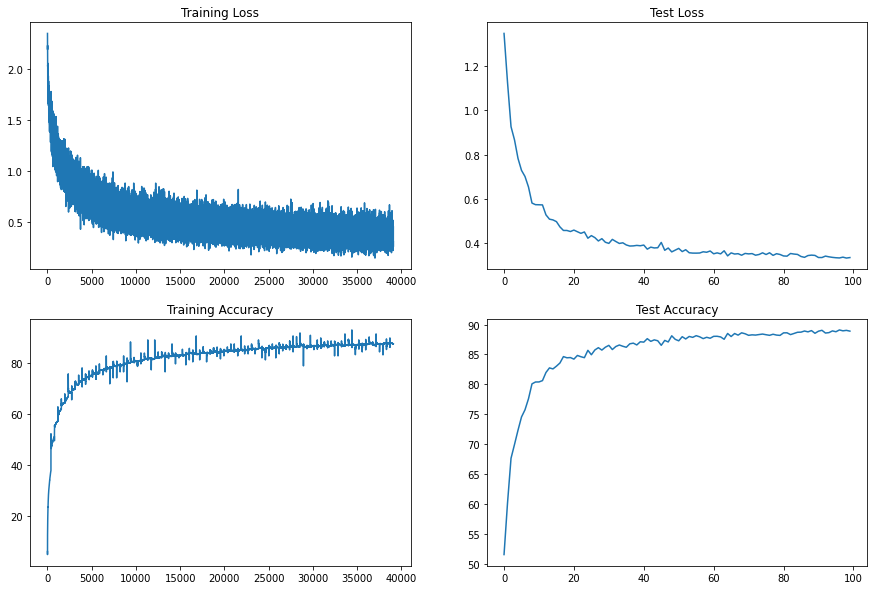

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:  plane   dog  bird truck


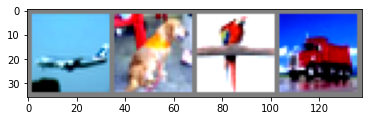

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images[:4].cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = model(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  plane   dog  bird truck


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 88 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 80 %
Accuracy of   car : 95 %
Accuracy of  bird : 78 %
Accuracy of   cat : 77 %
Accuracy of  deer : 97 %
Accuracy of   dog : 72 %
Accuracy of  frog : 88 %
Accuracy of horse : 81 %
Accuracy of  ship : 100 %
Accuracy of truck : 93 %
